<center><h1>M1 MMA - Optimisation</h1><h2>TP3 : descente de gradient par rebroussement d'Armijo</h2></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
params = {'tex.usetex': True}

<h2>I - Application à un problème de classification</h2>

In [2]:
# Paramètres pour générer les données du problème.
t = 2*np.pi*np.random.rand()
u = np.array([np.cos(t), np.sin(t)])
#

On considère donnée une famille de couples $((x_i,y_i))_{0\leq i\leq M-1}$ où pour tout $i$, $x_i$ est un point du plan $\mathbb{R}^2$ et $y_i\in\{-1,1\}$ défini l'appartenance de $x_i$ à une des deux classes représentées par les nombres $-1$ et $1$.

Les couples $((x_i,y_i))_{0\leq i\leq M-1}$ sont une réalisation d'un échantillon de taille $M$ de la variable aléatoire $(X,Y)$ à valeurs dans $\mathbb{R}^2\times\{-1,1\}$, c'est-à-dire une réalisation de $M$ variables aléatoires indépendantes $(X_i,Y_i)$ de même loi que le couple $(X,Y)$.

Une réalisation de la variable $(X,Y)$ est donnée par la fonction $\mbox{genererCouple}$ suivante :

In [3]:
def genererCouple():
    # renvoie une réalisation de la variable aléatoire (X,Y)
    if np.random.rand() < 0.5:
        x, y = 2.*np.random.randn(2) + 3*u, -1 # bleu
    else:
        x, y = 2.*np.random.randn(2) - 3*u, 1 # rouge
    return [x, y]

La cellule suivante génère les données du problème $((x_i,y_i))_{0\leq i\leq M-1}$ et les affiche graphiquement. La population de type "-1" (c'est-à-dire les $x_i$ tels que $y_i=-1$) est affichée en vert et celle de type "1" en rouge. Les $x_i$ sont stockés dans un vecteur $\mbox{xi_list}$ et les $y_i$ dans un vecteur $\mbox{yi_list}$.

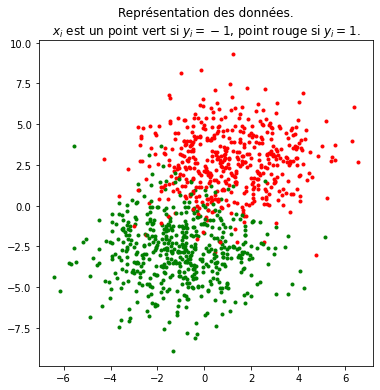

In [4]:
# génération des données
M = 1000
xi_list, yi_list = np.zeros((M, 2)), np.zeros(M)
for i in range(M):
    xi_list[i, :], yi_list[i] = genererCouple() # on stocke les données ((x_i, y_i))_i

# affichage
plt.figure(figsize = (6, 6))
for i in range(M):
    if yi_list[i] == 1: # si x_i est de classe 1 alors on affiche un point rouge
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "red")
    else: # sinon x_i est de classe -1 alors on affiche un point vert
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "green")
plt.title(u"Représentation des données.\n" + r"$x_i$ est un point vert si $y_i = -1$, point rouge si $y_i = 1$.")
plt.axis("tight")
plt.show()

L'objectif de ce TP est, à partir des données d'entraînement ci-dessus $((x_i,y_i))_{0\leq i\leq M-1}$, d'apprendre à prédire, sachant une nouvelle réalisation $x\in\mathbb{R}^2$ de $X$, la classe de $x$ associée.

Pour cela on va déterminer la meilleure droite passant par $(0,0)$ qui sépare les deux classes ou populations (vert et rouge / $-1$ et $1$) des données.

Une droite qui passe par $(0,0)$ a pour équation $f_a(x) = 0$ où $f_a : x\in\mathbb{R}^2 \mapsto a_0 x_0 + a_1 x_1$ avec $a = (a_0, a_1)\in\mathbb{R}^2$ un vecteur normal de la droite.

L'idée est donc de trouver la meilleure orientation (paramétrée par $a\in\mathbb{R}^2$) d'une droite, de sorte qu'une nouvelle réalisation $x$ de $X$ satisfaisant $f_a(x) > 0$ serait associée à la classe $y=1$ et $f_a(x) < 0$ serait associée à la classe $y = -1$.

Pour déterminer cette meilleure orientation $a\in\mathbb{R}^2$, nous allons chercher à résoudre le problème d'optimisation suivant : 
$$
    \min_{a\in\mathbb{R}^2} \ F(a), \quad \mbox{ où } F:a\in\mathbb{R}^2\mapsto \lambda \|a\|_2^2 + \frac1M \sum_{i=0}^{M-1} \log(1 + e^{-y_i (a_0 x_{i,0} + a_1 x_{i,1})}),
$$
où $\lambda > 0$ est un paramètre fixé et les $x_i = (x_{i,0}, x_{i,1})\in\mathbb{R}^2$ et $y_i\in\{-1,1\}$ sont les données du problème. Ici $\log$ représente le logarithme népérien.

<h3>Résolution numérique du problème d'optimisation</h3>

L'implémentation de $F$ est donnée ci-dessous.

On définit $\mbox{y_a}$ comme le résultat du produit matriciel entre $\mbox{xi_list}$ et $a$.
Ainsi d'après le modèle décrit au-dessus, le signe des coefficients de $\mbox{y_a}$ donne la classe des points $x_i$ prédites grâce à la séparation donnée par la droite de vecteur normal $a$.

In [5]:
λ = 0.05
def F(a):
    # implémentation vectorialisée de F
    y_a = np.dot(xi_list, a)
    L = np.log(1 + np.exp(-yi_list*y_a))
    return λ*np.dot(a, a) + 1/M*np.sum(L)

<b>1) Calculer le gradient de $F$ en $a\in\mathbb{R}^2$. On pourra introduire la fonction $g :t\in\mathbb{R}\mapsto\log(1+e^{-t})$.</b>

On a pour tout $a\in\mathbb R^2$, $\nabla F(a) = 2\lambda a + \frac1M\sum_{i=0}^{M-1} g'(y_i\langle x_i, a \rangle) y_i x_i$, où pour tout $t\in\mathbb{R}$, $g'(t) = -\frac{e^{-t}}{1+e^{-t}}$.

<b>2) Montrer que le problème d'optimisation admet une unique solution sur $\mathbb{R}^2$.</b>

On a pour tout $a\in\mathbb{R}^2$, $F(a) \geq \lambda \|a\|^2$. Donc $F(a) \to +\infty$ quand $\|a\|\to+\infty$. $F$ est donc coercive sur $\mathbb{R}^2$. Elle y est également continue, d'où $F$ admet au moins un minimum global sur $\mathbb{R}^2$.

Montrons que $F$ est strictement convexe. Pour cela calculons la hessienne. Soit $a\in\mathbb{R}^2$. On a
\begin{align*}
    \nabla F(a+h) &= 2\lambda a + 2\lambda h + \frac1M \sum_{i=0}^{M-1} g'(y_i \langle x_i, a\rangle + y_i \langle x_i, h\rangle) y_i x_i,\\
        &= 2\lambda a + 2\lambda h + \frac1M \sum_{i=0}^{M-1} g'(y_i \langle x_i, a\rangle) + g''(y_i \langle x_i, a\rangle) y_i^2 \langle x_i, h\rangle) x_i + o_{h\to0}(h),\\
        &= \nabla F(a) + 2\lambda h + \frac1M \sum_{i=0}^{M-1} g''(y_i \langle x_i, a\rangle) \underbrace{x_i^T h}_{\in\mathbb{R}} x_i + o_{h\to0}(h),\\
        &= \nabla F(a) + 2\lambda h + \frac1M \sum_{i=0}^{M-1} g''(y_i \langle x_i, a\rangle) x_ix_i^T h  + o_{h\to0}(h),
\end{align*}
d'où par identification, $\nabla^2 F(a) = 2\lambda I_2 + \frac1M \sum_{i=0}^{M-1} g''(y_i \langle x_i, a\rangle) x_ix_i^T$

On vérifie que pour tout $t\in\mathbb{R}$, $g''(t) \geq 0$. Et pour tout $i$, $x_ix_i^T$ est une matrice symétrique $2\times 2$ positive, puisque pour tout $h\in\mathbb{R}^2$, $h^Tx_i x_i^Th = (h^T x_i)^2 = (\langle h, x_i\rangle)^2 \geq 0$. Par conséquent pour tout $a\in\mathbb{R}^2$, $\nabla^2 F(a) \succeq 2\lambda I_2 \succ 0$, i.e. $F$ est strictement convexe sur $\mathbb{R}^2$.

Donc $F$ admet exactement un minimum global sur $\mathbb{R}^2$.

<b>3) Ecrire en Python une fonction $\mbox{gradF}$ prenant en argument $a\in\mathbb{R}^2$ et renvoyant $\nabla F(a)$.</b>

In [6]:
def dg(t):
    # dérivée de g
    u = np.exp(-t)
    return -u/(1 + u)

def gradF(a):
    # implementation vectorialisée du calcul du gradient de F
    y_a = np.dot(xi_list, a)
    A = yi_list*dg(y_a*yi_list)
    return 2*λ*a + 1/M*np.dot(A.transpose(), xi_list)

In [7]:
# Valider cette case pour vérifier que votre implémentation du gradient de F est correcte
a = np.random.rand(2)
epsilon = 1e-8
print("Cette quantité doit être inférieure à 1e-6 : ", np.linalg.norm(gradF(a) - np.array([(F(a + epsilon*np.array([1,0])) - F(a))/(epsilon), (F(a + epsilon*np.array([0,1])) - F(a))/(epsilon)])))

Cette quantité doit être inférieure à 1e-6 :  1.811970943971338e-08


<b>4) Ecrire en Python une fonction $\mbox{descente_gradient_rebroussement}$ prenant en argument la fonction objectif $f$, son gradient $\mbox{gradf}$, $\mbox{x0}$ (un point de départ), $\alpha$ et $\beta$ (pour la méthode du rebroussement d'Armijo), $\mbox{epsilon}$ (une tolérance), et $\mbox{Niter}$ (un nombre d'itérations maximum); implémentant l'algorithme de la descente de gradient par rebroussement d'Armijo. La fonction renverra la valeur du dernier itéré ainsi que la liste des itérés successifs. On fera attention à évaluer les fonctions $f$ et $\mbox{gradf}$ le moins de fois possible.

On pourra éventuellement implémenter à part une fonction codant la méthode du calcul d'un pas de descente par rebroussement d'Armijo.</b>

In [8]:
def rebroussement_armijo(f, x, gradfx, d, α, β):
    fx = f(x)
    γ = np.dot(gradfx, d)
    t = 1
    while f(x + t*d) > fx + α*t*γ:
        t = β*t
    return t

def descente_gradient_rebroussement(f, gradf, x0, α, β, ε = 1e-4, Niter = 1000):
    x, x_list = x0, [x0]
    d = -gradf(x)
    k = 0
    while np.linalg.norm(d) > ϵ and k < Niter:
        t = rebroussement_armijo(f, x, -d, d, α, β)
        x = x + t*d
        d = -gradF(x)
        x_list.append(x)
        k += 1
    return x, x_list

<b>5) Illustrer la converge de l'algorithme en utilisant la fonction $\mbox{plt.semilogy}$. (Indication : on utilisera d'abord l'algorithme avec une tolérance faible, par exemple $10^{-8}$, et on utilisera l'approximée obtenu comme limite de référence).</b>

In [9]:
a0 = np.array([1, -1.2])
# a_star est utilisé dans l'illustration de la convergence ci-dessous comme représentant le minimum global
a_star, a_list = descente_gradient_rebroussement(F, gradF, a0, 0.1, 0.7, 1e-10)
a_approx, a_list = descente_gradient_rebroussement(F, gradF, a0, 0.1, 0.7, 1e-6)

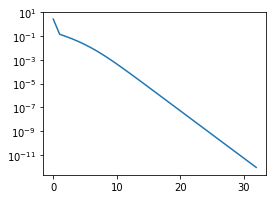

In [10]:
plt.figure(figsize = (4, 3))
plt.semilogy(range(len(a_list)),[abs(F(a) - F(a_star)) for a in a_list])
plt.show()

<b>6) De quel type de convergence s'agit-il ? Justifier.</b>

Convergence linéaire, comme prévu par le cours, car on a asymptotiquement une droite sur ce graphe dont les ordonnées sont en échelle log. 

<b>7) Vérifier la trajectoire obtenue via l'algorithme de descente avec les lignes de niveau de $F$.</b>

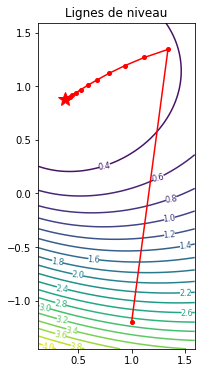

In [11]:
# Definition des grilles et evaluation de f
a_list_0 = [a_list[i][0] for i in range(len(a_list))] # on recupère les abscisses des itérés
a_list_1 = [a_list[i][1] for i in range(len(a_list))] # on recupère les ordonnées des itérés
a_0_min, a_0_max = np.min(a_list_0) - .25, np.max(a_list_0) + .25 # on définit les bornes des abscisses pour le graphe
a_1_min, a_1_max = np.min(a_list_1) - .25, np.max(a_list_1) + .25 # on définit les bornes des ordonnées pour le graphe
s = 100
a_0 = np.linspace(a_0_min, a_0_max, s) # grille abscisses
a_1 = np.linspace(a_1_min, a_1_max, s) # grille ordonnées
a_0, a_1 = np.meshgrid(a_0, a_1) # grille abcisses, grille ordonnées -> grille 2D
Z = np.zeros((s, s))
for i in range(s):
    for j in range(s):
        Z[i, j] = F([a_0[i, j], a_1[i, j]]) # valeurs de F sur la grille 2D

# Graphique des lignes de niveaux
fig, ax = plt.subplots(figsize = (6, 6))
CS = ax.contour(a_0, a_1, Z, 25)

plt.plot(a_list_0, a_list_1, marker = "o", ms = 4.0, color = "red")
plt.plot(a_star[0], a_star[1], marker = '*', ms = 15.0, color = "r")
ax.clabel(CS, fontsize = 8)
ax.set_title('Lignes de niveau')
ax.set_aspect('equal', adjustable = 'box')

<b>8) On considère la fonction $\mbox{f}$ suivante, où $\mbox{a_star}$ représente l'approximation de la solution renvoyée par l'algorithme.</b>

In [12]:
def sigmoid(t):
    return 2/(1 + np.exp(-2*t)) - 1

In [13]:
def prediction(x):
    return sigmoid(x[0]*a_star[0] + x[1]*a_star[1])

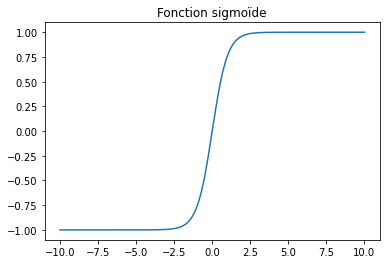

In [14]:
tt = np.linspace(-10, 10, 200)
plt.plot(tt, sigmoid(tt))
plt.title("Fonction sigmoïde")
plt.show()

La fonction $\mbox{sigmoid}$ représente la fonction sigmoïde, https://fr.wikipedia.org/wiki/Sigmoïde_(mathématiques), (ici modifiée pour que $\mbox{sigmoid}(0) = 0$ et $\mbox{sigmoid}(+\infty) = 1$ et $\mbox{sigmoid}(-\infty) = -1$) et assure que pour des grandes valeurs de $t$, celle-ci retourne $1$ et des grandes valeurs (négatives) $-1$. L'interpolation entre ces deux valeurs se faisant de manière progressive dans un voisinage de $0$.

Les valeurs nulles de la fonction $x\mapsto \langle x, \mbox{a_star} \rangle$ sont par définition les $x\in\mathbb{R}^2$ appartenant à la droite passant par $(0,0)$ de normale $\mbox{a_star}$. C'est la droite trouvée séparant de manière optimale, pour le critère définie par $F$, les points $x_i$ en fonction de leurs classes $\pm 1$. Quand $\langle x, \mbox{a_star}\rangle$ est grand "positif", alors on prédit (par construction du modèle et de $F$) que $x$ a pour classe $+1$. Quand $\langle x, \mbox{a_star}\rangle$ est grand "négatif", alors on prédit que $x$ a pour classe $-1$. Appliquer $\mbox{sigmoid}$ à $\langle x, \mbox{a_star}\rangle$, donnant la valeur renvoyée par $prediction(x)$, permet donc d'obtenir ces prédictions avec une transition progressive lorsque $\langle x, \mbox{a_star}\rangle$ est proche de $0$, c'est-à-dire lorsque l'on n'est pas sûr de la classe du point $x$.

En résumé, si $x$ est par exemple tel que $prediction(x)$ est très proche de $1$ alors, vu le modèle et les données, on a une bonne confiance que $x$ a pour classe $+1$. Si par contre $prediction(x) = -0.1$, alors le modèle penche plutôt pour la classe $-1$, mais pas avec une grande confiance.

<b>Interpréter la figure suivante.</b>

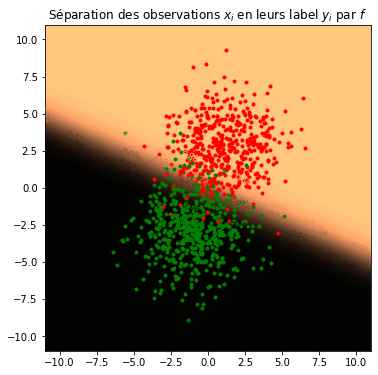

In [15]:
X0 = np.linspace(-11, 11, 100)
X1 = np.linspace(-11, 11, 100)
X0, X1 = np.meshgrid(X0, X1)
Z = prediction([X0, X1])

# Graphique des lignes de niveaux
fig, ax = plt.subplots(figsize = (6, 6))
CS = ax.contourf(X0, X1, Z, 50, cmap = "copper")
for i in range(M):
    if yi_list[i] == 1:
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "red")
    else:
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "green")
ax.clabel(CS, fontsize = 8)
ax.set_title(r"Séparation des observations $x_i$ en leurs label $y_i$ par $f$")
ax.set_aspect("equal", adjustable = "box") # pour que les axes aient la même échelle

Représentation de la distribution des points $x_i$ avec leurs classes $\pm1$. La colormap en fond représente la fonction $\mbox{prediction}$ en fonction de la localisation dans $\mathbb{R}^2$. La couleur noir représente les valeurs proche de $-1$ et la couleur marron les valeurs proches de $1$.

<h3>II) Application au débruitage d'images</h3>

In [16]:
def ps(x, y):
    # produit scalaire entre x et y, qui peuvent être des vecteurs ou des matrices.
    return np.sum(x*y)

Ci-dessous voici la méthode de descente de gradient adaptée pour fonctionner dans le contexte d'étude de cette seconde partie. Le produit scalaire utilisé est celui implémenté juste au dessus. Il permet de calculer le produit scalaire entre deux matrices, alors que la fonction np.dot renverrait le produit matriciel.

In [17]:
def rebroussement_armijo(f, x, gradfx, d, α, β):
    fx = f(x)
    γ = ps(gradfx, d)
    t = 1
    while f(x + t*d) > fx + α*t*γ:
        t = β*t
    return t

def descente_gradient_rebroussement(f, gradf, x0, α, β, ε = 1e-4, Niter = 1000):
    x, x_list = x0, [x0]
    d = -gradf(x)
    k = 0
    while np.linalg.norm(d)/f(x) > ϵ and k < Niter:
        t = rebroussement_armijo(f, x, -d, d, α, β)
        x = x + t*d
        d = -gradF(x)
        x_list.append(x)
        k += 1
    print("Nbre iter : ", k)
    return x, x_list

Récupérer l'image à l'adresse : https://qdenoyelle.github.io/M1_Optim/TP/hameau.png et la placer dans le dossier où le TP se situe.

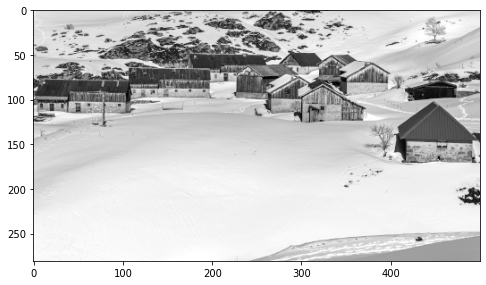

In [18]:
plt.figure(figsize = (8, 6))
img_original = plt.imread("hameau.png").astype(float) # chargement de l'image
img_original = sum([img_original[:, :, i] for i in range(2)]) # on transforme l'image en noir et blanc
img_original = 1/(np.max(img_original)-np.min(img_original))*(img_original - np.min(img_original))
plt.imshow(img_original, cmap = 'gray') # affichage de l'image
plt.show()

On va traiter l'image comme une matrice dont les coefficients sont le niveau de gris des pixels.

In [19]:
n, m = img_original.shape # on récupère le nombre de ligne et de colonnes.
print("Nombre de lignes : ", n)
print("Nombre de colonnes : ", m)

Nombre de lignes :  281
Nombre de colonnes :  500


On va maintenant dégrader l'image par un bruit additif gaussien (en pratique on aurait uniquement accès à l'image bruitée, ici on cré "artificiellement" le bruit).

In [20]:
bruit = .2 * np.random.randn(n, m) # bruit gaussien qui va être appliqué sur l'image
img_bruit = img_original + bruit # on bruite additivement l'image

<b>1) Afficher l'image bruitée.</b>

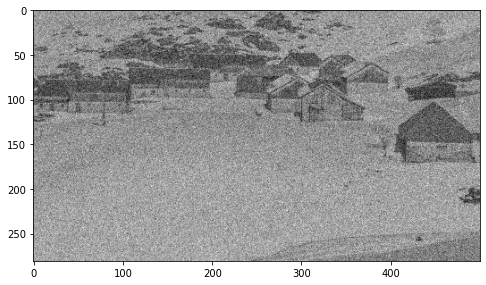

In [21]:
plt.figure(figsize = (8, 6))
plt.imshow(img_bruit, cmap = "gray") # affichage de l'image
plt.show()

Dans la suite les images seront vues comme des tableaux de valeurs (chaque pixel est un nombre représentant le niveau de gris), c'est à dire des matrices à $n$ lignes et $m$ colonnes.

On va maintenant chercher à débruiter l'image ci-dessus (i.e. diminuer l'impact du bruit). La méthode adoptée va consister à résoudre le problème d'optimisation suivant
$$
\min_{x\in\mathcal{M}_{n,m}(\mathbb{R})} F(x),
$$
où
$$
F(x) = \frac12 \sum_{i=1}^n\sum_{j=1}^m (x_{i,j} - y_{i,j})^2 + \lambda \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon(x_{i+1,j} - x_{i,j}) + \lambda \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon(x_{i,j+1} - x_{i,j}).
$$
$y\in\mathcal{M}_{n,m}(\mathbb{R})$ est l'image bruitée (la donnée du problème), $\lambda>0$ une constante et 
$$
\forall t\in\mathbb R, \quad N_\varepsilon(t) = \sqrt{t^2+\varepsilon},
$$
avec $\varepsilon>0$.

In [22]:
y = img_bruit # on stocke dans y l'image bruitée 

<b>3) Interpréter $F$.</b>

$F$ est composé de trois termes. Le premier, qui se réécrit $\frac12 \|x - y\|^2$ où $\|\cdot\|$ représente la distance euclidienne sur l'espace des matrices considéré ici (issue du produit scalaire canonique $\langle A,B\rangle = \mbox{Tr}(AB^T)$), représente un terme d'attache aux données : il mesure l'erreur quadratique au carrée entre une estimation $x$ et la donnée du problème $y$ (l'image bruitée). Les deux autres termes mesurent la variation de $x$ entre deux pixels successifs respectivement verticalement et horizontalement. En minimisant cette fonction objectif, on peut donc espérer obtenir une solution ($F$ admet un unique minimum global, cf ci-dessous) qui est proche de l'image bruitée (qui représente la donnée du problème) tout en lissant les variations locales : on atténue ainsi l'impact du bruit. Le compromis entre être proche des données et l'atténuation du bruit est controlé par le paramètre $\lambda$ (plus $\lambda$ est grand plus l'image sera lissée car les deux derniers termes deviennent plus pénalisant s'ils sont grands).

<b>4) Justifier que $F$ est $\mathcal C^\infty$ sur $\mathcal{M}_{n,m}(\mathbb{R})$. Montrer que $F$ est strictement convexe et admet un unique minimum global sur $\mathcal{M}_{n,m}(\mathbb{R})$.</b>

Le premier terme composant $F$ est polynomiale en les coefficients de $x\in\mathcal{M}_{n,m}(\mathbb{R})$. Ensuite $N_\varepsilon$ est $\mathcal{C}^{\infty}$ sur $\mathbb{R}$. Donc par sommes et composés de fonctions $\mathcal{C}^{\infty}$, $F$ est $\mathcal C^\infty$ sur $\mathcal{M}_{n,m}(\mathbb{R})$.

La fonction $f:x\in\mathcal{C}^{\infty}\mapsto \frac12 \|x - y\|^2$ est strictement convexe car sa matrice hessienne est la matrice $I_{nm}$ qui est définie positive. Attention ici à la dimension de la matrice hessienne : comme $x$ est une matrice, l'espace vectoriel considéré ici est de dimension $nm$. En effet, la matrice hessienne en un $x\in\mathcal{M}_{n,m}(\mathbb{R})$ est la matrice de la différentielle seconde $d^2f(x)$ qui est ici le produit scalaire canonique sur $\mathcal{M}_{n,m}(\mathbb{R})$ (vérifiez que la différentielle de $f$ en $x$, $d f(x)$, vaut $\langle x, \cdot \rangle$, puis re-différenciez en $x$) c'est-à-dire $I_{nm}$. Alternativement, $\nabla f(x) = x$ et en différentiant de nouveau par rapport à $x$, on obtient $d(\nabla f)(x)(h) = h = I_{nm} h = \nabla^2 f(x) h$.

Ensuite, on vérifie aisément que $N_\varepsilon$ est convexe sur $\mathbb{R}$ (il suffit par exemple de calculer sa dérivée seconde et vérifier qu'elle est positive sur $\mathbb{R}$). Donc pour tout $i, j$, $x\in\mathcal{M}_{n,m}(\mathbb{R})\mapsto N_\varepsilon(x_{i+1,j} - x_{i,j})$ et $x\in\mathcal{M}_{n,m}(\mathbb{R})\mapsto N_\varepsilon(x_{i,j+1} - x_{i,j})$ sont convexes car ce sont des composés entre des fonctions convexes et des fonctions linéaires. Attention la composée de deux fonctions convexes n'est pas convexe en général par contre convexe avec linéaire oui (le redémontrer en exercice). Donc comme la somme de fonctions convexes est convexe, on a bien
$$
    R:x\in\mathcal{M}_{n,m}(\mathbb{R})\mapsto \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon(x_{i+1,j} - x_{i,j}) + \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon(x_{i,j+1} - x_{i,j}),
$$
est convexe. En fait il se trouve que $R$ est même strictement convexe car $N_\varepsilon$ est strictement convexe mais on en a pas besoin pour conclure que $F$ est strictement convexe (voir ci-dessous).

Enfin $f$ est strictement convexe, $R$ est convexe donc $F = f + \lambda R$ est strictement convexe sur $\mathcal{M}_{n,m}(\mathbb{R})$.

Comme $F$ est strictement convexe, $F$ admet au plus un minimum global sur $\mathcal{M}_{n,m}(\mathbb{R})$. Montrons que $F$ est coercive. La fonction $f$ l'est car pour tout $x$, $f(x)\geq \frac12(\|x\| - \|y\|)^2$ par inégalité triangulaire inverse. D'où $f(x)\to+\infty$ quand $\|x\|\to+\infty$. Puis $N_\varepsilon$ est une fonction positive donc pour tout $x$, $F(x)\geq f(x)$. D'où $F$ est bien coercive. Elle est aussi continue, donc elle admet un minimum global sur $\mathcal{M}_{n,m}(\mathbb{R})$, qui est par conséquent unique.

<b>5) Voici ci-dessous une implémentation vectorialisée du gradient de $F$. Les matrices $L\in\mathcal{M}_{n-1, n}(\mathbb{R})$ avec des $-1$ sur la diagonale, et des $1$ sur la sur-diagonale, et $C\in\mathcal{M}_{m, m-1}(\mathbb{R})$ la matrice avec des $-1$ sur la diagonale, $1$ sur la sous-diagonale ont été introduites</b>.

Cette implémentation vectorielle du gradient est justifiée par ces calculs théoriques qui fournissent une écriture "matricielle" du gradient de $F$.

Soit $x\in\mathcal{M}_{n,m}(\mathbb{R})$, on a $\nabla F(x) = \nabla f(x) + \lambda\nabla R(x)$ en reprenant les notations introduites à la question précédente pour $f$ et $R$. Or $\nabla f(x) = x - y$. On a pour tout $h\in\mathcal{M}_{n,m}(\mathbb R)$ 
\begin{align}
    R(x + h) &= R(x) + \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon'(x_{i+1,j} - x_{i,j})(h_{i+1,j} - h_{i,j}) + \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon'(x_{i,j+1} - x_{i,j})(h_{i,j+1} - h_{i,j}) + o(\|h\|).\\
\end{align}
On reconnaît que $\sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon'(x_{i+1,j} - x_{i,j})(h_{i+1,j} - h_{i,j})$ est un produit scalaire entre la matrice de taille $n-1 \times m$ et de coefficient $(i,j)$ : $N_\varepsilon'(x_{i+1,j} - x_{i,j})$ et la matrice de taille $n-1 \times m$ et de coefficient $(i,j)$ : $h_{i+1,j} - h_{i,j}$. Cette dernière matrice s'écrit $Lh$ où $L\in\mathcal{M}_{n-1,m}(\mathbb{R})$ est définie avec des $-1$ pour les coefficients $(i,i)$ et $1$ pour les coefficients $(i,i+1)$. En posant la fonction $N_{\varepsilon,(n-1,m)}':\mathcal{M}_{n-1,m}(\mathbb{R})\to \mathcal{M}_{n-1,m}(\mathbb{R})$ définie par
$$
    \forall y\in\mathcal{M}_{n-1,m}(\mathbb{R}), \quad N_{\varepsilon,(n-1,m)}'(y) = \left(N_\varepsilon'(y_{i,j})\right)_{1\leq i\leq n-1 ; \, 1\leq j\leq m},
$$
qui revient à appliquer la fonction $N_\varepsilon':\mathbb R\to\mathbb R$ à tous les coefficients de la matrice $y$, on déduit alors que
$$
    \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon'(x_{i+1,j} - x_{i,j})(h_{i+1,j} - h_{i,j}) = \langle N_{\varepsilon,(n-1,m)}'(Lx), Lh\rangle = \langle L^T N_{\varepsilon,(n-1,m)}'(Lx), h\rangle.
$$
Similairement, en posant $C\in\mathcal{M}_{m,m-1}(\mathbb{R})$ la matrice avec des $-1$ pour les coefficients $(i,i)$ et $1$ pour les $(i+1,i)$, et $N_{\varepsilon,(n,m-1)}'$ définie comme $N_{\varepsilon,(n-1,m)}'$ mais cette fois pour des $y\in\mathcal{M}_{n-1,m}(\mathbb{R})$, on remarque que 
$$
    \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon'(x_{i,j+1} - x_{i,j})(h_{i,j+1} - h_{i,j}) = \langle N_{\varepsilon,(n,m-1)}'(xC), hC\rangle = \langle N_{\varepsilon,(n,m-1)}'(xC)C^T, h\rangle,
$$
où pour la dernière égalité on a utilisé : $\langle N_{\varepsilon,(n,m-1)}'(xC), hC\rangle = \mbox{Tr}(N_{\varepsilon,(n,m-1)}'(xC)^T(hC)) = \mbox{Tr}(N_{\varepsilon,(n,m-1)}'(xC)\, (hC)^T) = \mbox{Tr}(N_{\varepsilon,(n,m-1)}'(xC)C^Th)$.

Ainsi $ R(x + h) = R(x) + \langle L^T N_{\varepsilon,(n-1,m)}'(Lx) + N_{\varepsilon,(n,m-1)}'(xC)C^T, h\rangle + o(\|h\|)$ et donc
\begin{align}
    \nabla R(x) = L^T N_{\varepsilon,(n-1,m)}'(Lx) + N_{\varepsilon,(n,m-1)}'(xC)C^T.
\end{align}
On peut faire une analyse dimensionnelle pour vérifier que tout est cohérent. $\nabla R(x)$ est censé être une matrice de taille $n\times m$ ($R$ est une application de l'espace vectoriel $\mathcal M_{n,m}(\mathbb R)$ à valeurs dans $\mathbb R$, donc sa différentielle est une forme linéaire sur $\mathcal M_{n,m}(\mathbb R)$, et donc le gradient de $R$ existe et est un élément de l'espace vectoriel $\mathcal M_{n,m}(\mathbb R)$). Or $N_{\varepsilon,(n-1,m)}'(Lx)$ est de taillme $n-1\times m$ et $L^T$ de taille $n\times n-1$, donc c'est bon pour le premier terme. $N_{\varepsilon,(n,m-1)}'(xC)$ est de taille $n\times m-1$ (car $xC$ est une matrice de taille $n\times m-1$) et $C^T$ est de taille $m-1\times m$, donc c'est bon aussi pour le second.

Et donc
\begin{align}
    \nabla F(x) = x - y + \lambda L^T N_{\varepsilon,(n-1,m)}'(Lx) + \lambda N_{\varepsilon,(n,m-1)}'(xC)C^T.
\end{align}

<b>L'avantage de cette expression pour le gradient de $R$ est qu'elle est "vectorielle" : il n'y a pas de sommes, mais uniquement des produits matriciels et l'application de fonctions coefficient par coefficient (pour $N_{\varepsilon,(n,m-1)}'(xC)$ et $N_{\varepsilon,(n-1,m)}'(Lx)$). L'implémentation va donc être rapide en Python, car on va éviter les boucles for. Un autre calcul aurait pu être fait pour trouver ce gradient, mais elle aurait fait intervenir des sommes. Obtenir par la suite l'expression "vectorialisée" est néanmois moins visible sous cette forme. Je mets tout de même le calcul qui est tout à fait admissible et adapté pour une utilisation à des fins purement mathématiques. Et probablement plus facile à mettre en place.</b>

En remarquant que pour tout $i\in\{1,\ldots,n-1\}$, $j\in\{1,\ldots,m\}$, $N_\varepsilon(x_{i+1,j} - x_{i,j}) = N_\varepsilon(\langle \ell_{i,j}, x\rangle)$, avec $\ell_{i,j} = E_{i+1,j} - E_{i,j}$ et $E_{k,l}\in\mathcal{M}_{n,m}(\mathbb{R})$ la matrice avec $1$ en $(k,l)$ et $0$ partout sinon (les $E_{k,l}$ forment la base canonique de $\mathcal{M}_{n,m}(\mathbb{R})$). Puis pour tout $i\in\{1,\ldots,n\}$, $j\in\{1,\ldots,m-1\}$, $N_\varepsilon(x_{i,j+1} - x_{i,j}) = N_\varepsilon(\langle c_{i,j}, x\rangle)$, avec $c_{i,j} = E_{i,j+1} - E_{i,j}$. Ainsi on a 
$$
    \nabla R(x) = \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon'(x_{i+1,j} - x_{i,j})\ell_{i,j}^T + \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon'(x_{i,j+1} - x_{i,j})c_{i,j}^T.
$$

In [23]:
L = np.zeros([n - 1, n])
for i in range(n - 1):
    for j in range(n):
        if i == j:
            L[i, j] = -1
        if j == i + 1:
            L[i, j] = 1

C = np.zeros([m, m - 1])
for i in range(m):
    for j in range(m - 1):
        if i == j:
            C[i, j] = -1
        if i == j + 1:
            C[i, j] = 1

In [24]:
# En première lecture de cette question, vous pouvez vous concentrer sur les implémentations des fonctions données
# dans les "else".
#
# Elles correspondent à des implémentations "naïves" et directes des opérations demandées.
# Nous verrons plus tard qu'il est possible de réécrire ces opérations de manière plus efficace.
#
# Le booléen "implementation_efficace", que l'on fixera comme vrai ou faux à la demande, permettra
# de switcher entre l'une ou l'autre des implémentations pour tester la différence de vitesse d'éxécution.

implementation_efficace = True

def Lp(x):
    if implementation_efficace:
        return x[1:n, :] - x[0:n-1, :]
    else:
        return np.dot(L, x)
def Lt(v):
    if implementation_efficace:
        u = np.zeros([n , m])
        u[0, :] = -v[0, :]
        u[1:n-1, :] = v[0:n-2, :] - v[1:n-1, :]
        u[n-1, :] = v[n-2, :]
        return u
    else:
        return np.dot(L.transpose(), v)
def Cp(x):
    if implementation_efficace:
        return x[:, 1:m] - x[:, 0:m-1]
    else:
        return np.dot(x, C)
def Ct(v):
    if implementation_efficace:
        u = np.zeros([n , m])
        u[:, 0] = -v[:, 0]
        u[:, 1:m-1] = v[:, 0:m-2] - v[:, 1:m-1]
        u[:, m-1] = v[:, m-2]
        return u
    else:
        return np.dot(v, C.transpose())

In [25]:
epsilon = 1e-5
def N_eps(t):
    return np.sqrt(t**2 + epsilon)
def dN_eps(t):
    return t/N_eps(t)
def R(x):
    return np.sum(N_eps(Lp(x))) + np.sum(N_eps(Cp(x)))

In [26]:
def F(x):
    return .5*ps(x - y, x - y) + lbda*R(x)

Vu l'expression du gradient de $R$ :
\begin{align}
    \nabla R(x) = L^T N_{\varepsilon,(n-1,m)}'(Lx) + N_{\varepsilon,(n,m-1)}'(xC)C^T,
\end{align}
et les fonctions $\mbox{Lp}$, $\mbox{Lt}$, $\mbox{Cp}$, $\mbox{Ct}$ définies précédemment, on obtient directement la fonction $\mbox{gradR}$ ci-dessous.

In [27]:
def gradR(x):
    return Lt(dN_eps(Lp(x))) + Ct(dN_eps(Cp(x)))

In [28]:
def gradF(x):
    return x - y + lbda*gradR(x)

<b>6) Utiliser l'algorithme de descente de gradient par rebroussement d'Armijo pour le résoudre le problème d'optimisation. On prendra pour l'instant $\lambda = 0.3$.</b>

In [29]:
lbda = .3
alpha, beta = 1e-4, .2 # valeurs de alpha et beta qui donne une convergence relativement rapide de l'algorithme.
# Faites vos tests !

max_iter = 4000
tol = 1e-5

t_start = time()
x, x_list = descente_gradient_rebroussement(F, gradF, y, alpha, beta, tol, max_iter)
t_end = time()

print("--- FIN ---")
print("time = ", t_end - t_start)


Nbre iter :  1061
--- FIN ---
time =  9.692205905914307


<b>7) Illustrer la convergence de l'algorithme.</b>

In [30]:
max_iter = 4000
tol = 1e-5
x_star, x_list = descente_gradient_rebroussement(F, gradF, y, alpha, beta, tol, max_iter)


tol = 1e-4
x, x_list = descente_gradient_rebroussement(F, gradF, y, alpha, beta, tol, max_iter)

F_star = F(x_star)

Nbre iter :  1061
Nbre iter :  644


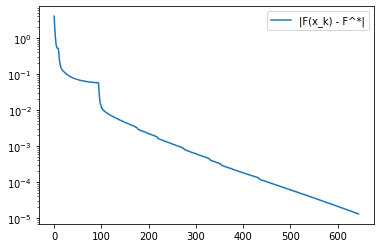

In [31]:
plt.semilogy([abs(F(x) - F_star)/F_star for x in x_list], label = "|F(x_k) - F^*|")
plt.legend()
plt.show()

On a toujours bien une convergence linéaire vu le comportement linéaire asymptotique de $\log(|F(x_k) - F^*|)$ !

<b>8) Afficher l'image reconstruite et la comparée aux autres images. Commenter.</b>

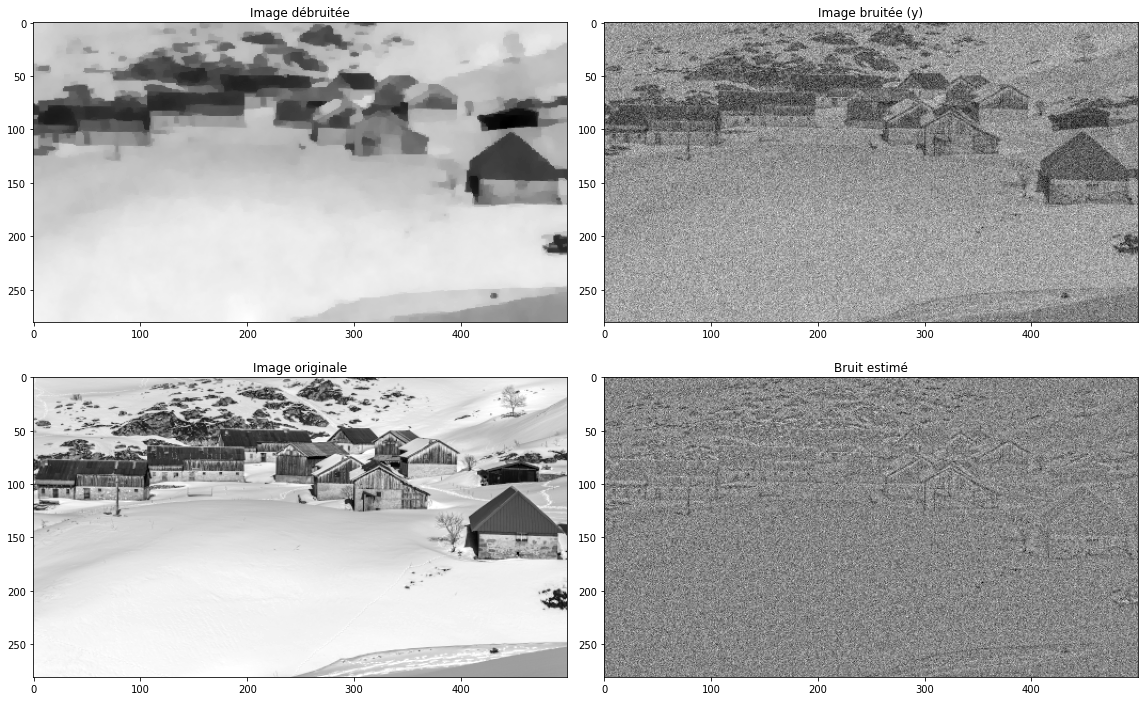

In [32]:
plt.figure(figsize = (16, 10))
#
plt.subplot(2, 2, 1)
plt.imshow(x, cmap = 'gray')
plt.title('Image débruitée')
#
plt.subplot(2, 2, 2)
plt.imshow(img_bruit, cmap = 'gray')
plt.title('Image bruitée (y)')
#
plt.subplot(2, 2, 3)
plt.imshow(img_original, cmap = 'gray')
plt.title('Image originale')
#
plt.subplot(2, 2, 4)
plt.imshow(img_bruit - x, cmap = 'gray')
plt.title('Bruit estimé')
plt.tight_layout()
plt.show()

On remarque l'effet cartoon produite par la méthode de reconstruction : on a des zones uniformes en niveau de gris. C'est à cause du fait que $N_{\varepsilon}$ approxime la valeur absolue quand $\varepsilon$ est petit. Ainsi on minimise (en plus du terme d'attache aux données), la norme $\ell_1$ du gradient de l'image. Or l'utilisation de la norme $\ell_1$ dans un problème d'optimisation a tendance à produire des vecteurs solutions avec beaucoup de $0$ (solutions dites parcimonieuses).  Ici l'image solution du problème va donc avoir un gradient avec beaucoup de $0$, c'est-à-dire une image de type constante par zones !

Dans le TP2, on considérait la norme $\ell_2$ du gradient, ce qui n'induit pas ce comportement. L'image reconstruite est simplement floutée.

Un avantage de la méthode de ce TP est que les contours sont mieux préservés.

<b>9) On considère la fonction $\mbox{snr}$ suivante qui donne une mesure de la qualité de la reconstruction (plus $\mbox{snr}(x)$ est grand, mieux c'est). Trouver une valeur de $\lambda$ qui donne une reconstruction proche de l'optimal pour cette métrique de performance.</b>

In [33]:
def snr(x):
    # fonction "Signal to Noise ratio"
    return -10*np.log(ps(x - img_original, x - img_original)/ps(x, x))/np.log(10)

In [35]:
tol = 1e-6
niter_max = 10000
for lbda in np.linspace(0.1, .17, 10):
    print("lambda = ", lbda)
    x_star, x_list = descente_gradient_rebroussement(F, gradF, y, alpha, beta, tol, max_iter)
    print("SNR = ", snr(x_star))
    print("")

lambda =  0.1
Nbre iter :  471
SNR =  20.992644076153457

lambda =  0.10777777777777778
Nbre iter :  592
SNR =  21.30232470379886

lambda =  0.11555555555555556
Nbre iter :  727
SNR =  21.519751329610564

lambda =  0.12333333333333334
Nbre iter :  1070
SNR =  21.654747110194776

lambda =  0.13111111111111112
Nbre iter :  1131
SNR =  21.719355774567273

lambda =  0.1388888888888889
Nbre iter :  1223
SNR =  21.727886403897443

lambda =  0.14666666666666667
Nbre iter :  1232
SNR =  21.69488639179914

lambda =  0.15444444444444444
Nbre iter :  1309
SNR =  21.632234525120687

lambda =  0.16222222222222224
Nbre iter :  1327
SNR =  21.549440327229114

lambda =  0.17
Nbre iter :  1381
SNR =  21.452995020038315



On choisit donc $\lambda = 0.139$ qui a un SNR de $\simeq 21.7$ dB.

In [36]:
lbda = .139 # semble être proche de l'optimum
alpha, beta = 1e-4, .2

implementation_efficace = True
max_iter = 10000

tol = 1e-6
x_star, x_list = descente_gradient_rebroussement(F, gradF, y, alpha, beta, tol, max_iter)

Nbre iter :  1221


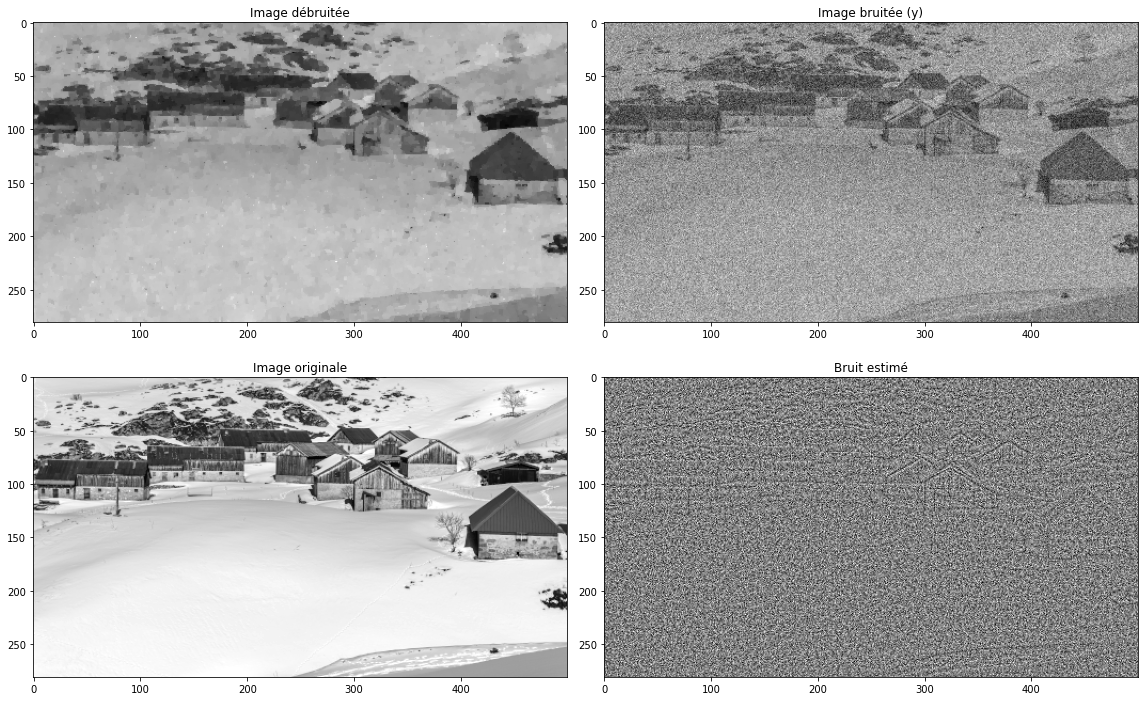

In [37]:
plt.figure(figsize = (16, 10))
#
plt.subplot(2, 2, 1)
plt.imshow(x_star, cmap = 'gray')
plt.title('Image débruitée')
#
plt.subplot(2, 2, 2)
plt.imshow(img_bruit, cmap = 'gray')
plt.title('Image bruitée (y)')
#
plt.subplot(2, 2, 3)
plt.imshow(img_original, cmap = 'gray')
plt.title('Image originale')
#
plt.subplot(2, 2, 4)
plt.imshow(img_bruit - x_star, cmap = 'gray')
plt.title('Bruit estimé')
plt.tight_layout()
plt.show()